2025-03-16 20:22:53,465 - INFO - Initialized NumerAPI client.
2025-03-16 20:22:53,793 - INFO - Listed available datasets and versions.
2025-03-16 20:22:53,795 - INFO - Fetched files available for download for the current version.
2025-03-16 20:22:54,801 - INFO - target file already exists
2025-03-16 20:22:54,802 - INFO - download complete
2025-03-16 20:22:54,807 - INFO - Downloaded and loaded feature metadata.
2025-03-16 20:22:54,808 - INFO - Selected feature set size.
2025-03-16 20:22:55,383 - INFO - target file already exists
2025-03-16 20:22:55,384 - INFO - download complete
2025-03-16 20:22:56,179 - INFO - Downloaded and loaded training data.
2025-03-16 20:22:56,931 - INFO - Downsampled training data to every 4th era.
2025-03-16 20:22:56,932 - INFO - Defined model parameters for data version: v5.0, feature set size: small, model parameters: n_estimators=2000, learning_rate=0.01, max_depth=5, num_leaves=2**5-1, colsample_bytree=0.1.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 688184, number of used features: 42
[LightGBM] [Info] Start training from score 0.500008


2025-03-16 20:23:15,966 - INFO - Trained model on training data.
2025-03-16 20:23:16,587 - INFO - target file already exists
2025-03-16 20:23:16,590 - INFO - download complete
2025-03-16 20:23:19,337 - INFO - Downloaded and loaded validation data.
2025-03-16 20:23:20,498 - INFO - Downsampled validation data to every 4th era.
2025-03-16 20:23:20,630 - INFO - Applied embargo to validation data.
2025-03-16 20:23:28,073 - INFO - Generated validation predictions.
2025-03-16 20:23:28,767 - INFO - Installed and imported scoring tools.
2025-03-16 20:23:29,733 - INFO - target file already exists
2025-03-16 20:23:29,735 - INFO - download complete
2025-03-16 20:23:30,359 - INFO - Downloaded and joined meta_model for validation.
/var/folders/0x/tmhm45c9325cw884pq90vcw40000gn/T/ipykernel_21757/156374722.py:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the ope

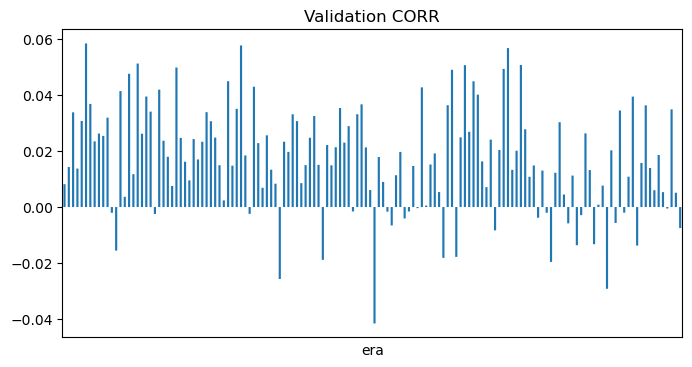

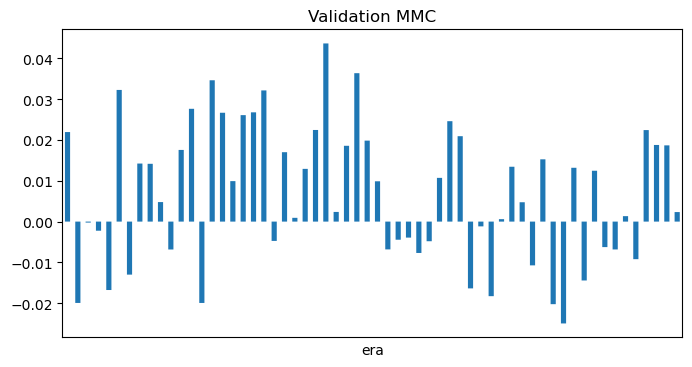

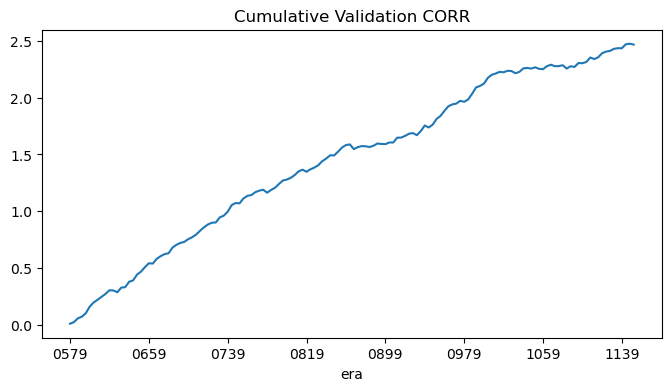

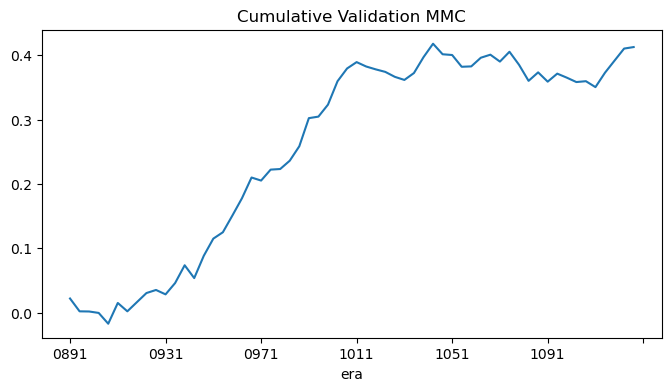

In [1]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
import json
import pandas as pd
import lightgbm as lgb
import cloudpickle
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
DATA_VERSION = "v5.0"
FEATURE_SET_SIZE = "small"

# Initialize API client
napi = NumerAPI()
logging.info("Initialized NumerAPI client.")

# List available datasets and versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
logging.info("Listed available datasets and versions.")

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
logging.info("Fetched files available for download for the current version.")

# Download and load feature metadata
napi.download_dataset(f"{DATA_VERSION}/features.json")
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
logging.info("Downloaded and loaded feature metadata.")

# Display feature set sizes
feature_sets = feature_metadata["feature_sets"]
feature_set = feature_sets[FEATURE_SET_SIZE]
logging.info("Selected feature set size.")

# Download and load training data
napi.download_dataset(f"{DATA_VERSION}/train.parquet")
train = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=["era", "target"] + feature_set
)
logging.info("Downloaded and loaded training data.")

# Downsample to every 4th era to reduce memory usage and speedup model training
train = train[train["era"].isin(train["era"].unique()[::4])]
logging.info("Downsampled training data to every 4th era.")

# Define model
model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2**5-1,
    colsample_bytree=0.1
)
logging.info(f"Defined model parameters for data version: {DATA_VERSION}, feature set size: {FEATURE_SET_SIZE}, model parameters: n_estimators=2000, learning_rate=0.01, max_depth=5, num_leaves=2**5-1, colsample_bytree=0.1.")

# Train model
model.fit(
    train[feature_set],
    train["target"]
)
logging.info("Trained model on training data.")

# Download and load validation data
napi.download_dataset(f"{DATA_VERSION}/validation.parquet")
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "data_type", "target"] + feature_set
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]
logging.info("Downloaded and loaded validation data.")

# Downsample validation data
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]
logging.info("Downsampled validation data to every 4th era.")

# Apply embargo to avoid data leakage
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]
logging.info("Applied embargo to validation data.")

# Generate validation predictions
validation["prediction"] = model.predict(validation[feature_set])
logging.info("Generated validation predictions.")

# Install and import scoring tools
!pip install -q --no-deps numerai-tools
from numerai_tools.scoring import numerai_corr, correlation_contribution
logging.info("Installed and imported scoring tools.")

# Download and join meta_model for validation
napi.download_dataset(f"v4.3/meta_model.parquet", round_num=842)
validation["meta_model"] = pd.read_parquet(
    f"v4.3/meta_model.parquet"
)["numerai_meta_model"]
logging.info("Downloaded and joined meta_model for validation.")

# Calculate performance metrics
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)
logging.info("Calculated performance metrics.")

# Plot correlation metrics
per_era_corr.plot(
    title="Validation CORR",
    kind="bar",
    figsize=(8, 4),
    xticks=[],
    legend=False,
    snap=False
)
per_era_mmc.plot(
    title="Validation MMC",
    kind="bar",
    figsize=(8, 4),
    xticks=[],
    legend=False,
    snap=False
)
logging.info("Plotted correlation metrics.")

# Plot cumulative metrics
per_era_corr.cumsum().plot(
    title="Cumulative Validation CORR",
    kind="line",
    figsize=(8, 4),
    legend=False
)
per_era_mmc.cumsum().plot(
    title="Cumulative Validation MMC",
    kind="line",
    figsize=(8, 4),
    legend=False
)
logging.info("Plotted cumulative metrics.")

# Calculate summary statistics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

# Display performance summary
summary_df = pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T
logging.info("Calculated and displayed performance summary.")

# Download and process live data
napi.download_dataset(f"{DATA_VERSION}/live.parquet")
live_features = pd.read_parquet(f"{DATA_VERSION}/live.parquet", columns=feature_set)
live_predictions = model.predict(live_features[feature_set])
logging.info("Downloaded and processed live data.")

# Define prediction pipeline function
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_set])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")
logging.info("Defined prediction pipeline function.")

# Serialize prediction function
p = cloudpickle.dumps(predict)
with open("hello_numerai.pkl", "wb") as f:
    f.write(p)
logging.info("Serialized prediction function.")

# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('hello_numerai.pkl')
    logging.info("Downloaded prediction function file.")
except:
    pass